<img src="images/convolutional_denoising_autoencoder.png">

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image

import imageio


class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # ====== ENCODER PART ======       
        # MNIST image is 1x28x28 (CxHxW)
        # Pytorch convolution expects input data as BxCxHxW 
        # B: Batch size
        # C: number of channels gray scale images have 1 channel
        # W: width of the image 
        # H: height of the image

        # use 32 3x3 filters with padding
        # padding is set to 1 so that image W,H is not changed after convolution
        # stride is 2 so filters will move 2 pixels for next calculation  
        # W after conv2d  [(W - Kernelw + 2*padding)/stride] + 1
        # after convolution we'll have Bx32 14x14 feature maps (28-3+2)/2 + 1 = 14
        self.conv1 = nn.Conv2d(in_channels=1,      # 1 channel because gray scaled image
                                out_channels=32,   # apply 32 filters and get a feature map for each filter
                                kernel_size=3,     # filters are 3x3 weights
                                stride=2,          # halves the size of the image
                                padding=1)


        
        # after convolution we'll have Bx64 7x7 feature maps 
        self.conv2= nn.Conv2d(in_channels=32,
                                out_channels=64,
                                kernel_size=3,
                                stride=2,
                                padding=1
                                )


        # first fully connected layer from 64*7*7=3136 input features to 16 hidden units
        self.fc1 = nn.Linear(in_features=64*7*7,
                                out_features=16)

        # ====== DECODER PART ======   
        self.fc2 = nn.Linear(in_features=16,
                                out_features=64*7*7)

        # 32 14x14
        # stride*(W–1) + – 2*padding + d*(K-1) + outpadding +1 = 2*(7-1)-2 + 2 +1 +1  =  14
        self.conv_t1 = nn.ConvTranspose2d(in_channels=64,
                                            out_channels=32,
                                            kernel_size=3,
                                            stride=2,
                                            padding=1,
                                            dilation=1,
                                            output_padding=1)                                


        # 1 28x28
        self.conv_t2 = nn.ConvTranspose2d(in_channels=32,
                                            out_channels=1,
                                            kernel_size=3,
                                            stride=2,
                                            padding=1,
                                            dilation=1,
                                            output_padding=1)                              

                           


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, start_dim=1) # flatten feature maps, Bx(C*H*W)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = x.view(-1,64,7,7) # reshape back to feature map format
        x = F.relu(self.conv_t1(x))
        x = torch.tanh(self.conv_t2(x))
        return x             


def to_img(x):
    x = 0.5 * (x + 1)   # from [-1, 1] range to [0, 1] range
    x = x.clamp(0, 1)   # assign less than 0 to 0, bigger than 1 to 1
    x = x.view(x.size(0), 1, 28, 28) # B, C, H, W format for MNIST
    return x

seed = 60
num_epochs = 61
batch_size = 512
learning_rate = 1e-3
n_batches = 60000 // batch_size

# manual seed to reproduce same results
torch.manual_seed(seed)

# normalize each image and set the pixel values between -1 and 1
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# prepare data loader
dataset = MNIST('./data', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=8)

# determine where to run the code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

# create an AutoEncoder network instance
net = AutoEncoder().to(device)
# print(net)  # display the architecture
loss_function = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,
                             weight_decay=1e-5)


def train(net, loader, loss_func, optimizer):
    net.train()                                      # put model in train mode
    total_loss = 0
    for img, _ in loader:                            # next batch
        img = img.to(device)                         # move to gpu if available
        noise = torch.randn(*img.shape).to(device)   # generate random noise        
        noised_img = img.masked_fill(noise > 0.5, 1) # set image values at indices where noise >0.5  to 1
        output = net(noised_img)                     # feed forward
        loss = loss_func(output, img)                # calculate loss 
        
        optimizer.zero_grad()                        # clear previous gradients 
        loss.backward()                              # calculate new gradients
        optimizer.step()                             # update weights 
        total_loss += loss.item()                    # accumulate loss
    return noised_img, img, output, total_loss


output_dir ="conv_auto_encoder_output"
losses=[]
for epoch in range(num_epochs):
    noised_img, img, output, loss = train(net, dataloader, loss_function, optimizer)
    # log
    print('epoch [{}/{}], loss:{:.4f}'
            .format(epoch+1, num_epochs, loss/n_batches))
    losses.append(loss/n_batches)
    if epoch % 10 == 0:
        pic_org = to_img(img.cpu().data)
        pic_noised = to_img(noised_img.cpu().data)
        pic_pred = to_img(output.cpu().data)
        res = torch.cat((pic_org,pic_noised,pic_pred), dim=2)
        save_image(res[:8], f'{output_dir}/res_{epoch}.png')  # save 8 iamges

# save the model
torch.save(net.state_dict(), f'{output_dir}/conv_autoencoder.pth')

epoch [1/61], loss:0.4964
epoch [2/61], loss:0.4452
epoch [3/61], loss:0.4436
epoch [4/61], loss:0.4411
epoch [5/61], loss:0.4363
epoch [6/61], loss:0.3794
epoch [7/61], loss:0.1899
epoch [8/61], loss:0.1593
epoch [9/61], loss:0.1484
epoch [10/61], loss:0.1424
epoch [11/61], loss:0.1380
epoch [12/61], loss:0.1346
epoch [13/61], loss:0.1319
epoch [14/61], loss:0.1295
epoch [15/61], loss:0.1275
epoch [16/61], loss:0.1259
epoch [17/61], loss:0.1245
epoch [18/61], loss:0.1229
epoch [19/61], loss:0.1215
epoch [20/61], loss:0.1204
epoch [21/61], loss:0.1194
epoch [22/61], loss:0.1183
epoch [23/61], loss:0.1172
epoch [24/61], loss:0.1165
epoch [25/61], loss:0.1158
epoch [26/61], loss:0.1151
epoch [27/61], loss:0.1144
epoch [28/61], loss:0.1136
epoch [29/61], loss:0.1129
epoch [30/61], loss:0.1127
epoch [31/61], loss:0.1119
epoch [32/61], loss:0.1114
epoch [33/61], loss:0.1108
epoch [34/61], loss:0.1103
epoch [35/61], loss:0.1100
epoch [36/61], loss:0.1094
epoch [37/61], loss:0.1089
epoch [38/

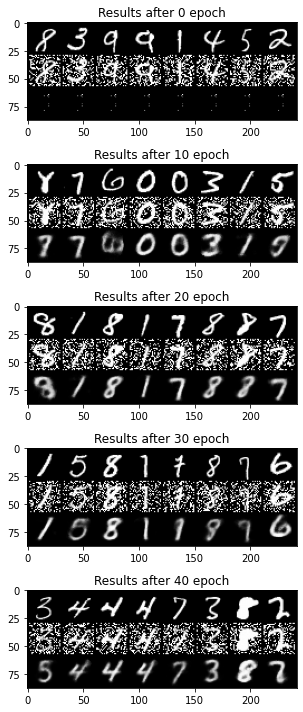

In [2]:
# show performance of autoencoder after some epochs
from matplotlib import pyplot as plt
imgs = [plt.imread(f'{output_dir}/res_{i*10}.png') for i in range(5)]

NUM_ROWS = 5
IMGS_IN_ROW = 1
f, ax = plt.subplots(NUM_ROWS, IMGS_IN_ROW, figsize=(20,10))

for i in range(5):
    ax[i].imshow(imgs[i])
    ax[i].set_title(f'Results after {10*i} epoch')

plt.tight_layout()
plt.show()

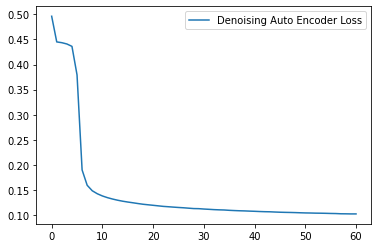

In [3]:
# plot and save autoencoder loss
plt.figure()
plt.plot(losses, label='Denoising Auto Encoder Loss')
plt.legend()
plt.savefig(f'{output_dir}/loss.png')